In [1]:
# %% imports
import torch
import torch.nn as nn
from torch.nn.modules.activation import ReLU



In [2]:
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()  # same as super().__init__()
        # how to find output shape: [input - kernel + 2*padding - (dilation-1)(kernel-1)]/stride + 1
        self.encoder = nn.Sequential(
            #  
            nn.Conv2d(1,16, kernel_size=(3,3),padding=1, stride=1), #[Nx1x32x32]=> [Nx16x32x32]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x32x32]=> [Nx16x16x16]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x16x16]=> [Nx16x16x16]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x16x16]=> [Nx16x8x8]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x8x8]=> [Nx16x8x8]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x8x8]=> [Nx16x4x4]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x4x4]=> [Nx16x4x4]
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x4x4]=> [Nx16x2x2]

            nn.Conv2d(16,1, kernel_size=(3,3),padding=1, stride=1), #[Nx16x2x2]=> [Nx1x2x2]
            nn.MaxPool2d((1,2)) #[Nx1x2x2]=> [Nx1x2x1]
        )
    def forward(self, x):
        # First branch uses dilation
        y = self.encoder(x)
        return y
    

    


In [3]:
# sanity
test_input = torch.rand(64,1,32,32)
model_test = Encoder()
test_out=model_test.forward(test_input)
print(test_out.size())

torch.Size([64, 1, 2, 1])


In [4]:
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # create layers here
            # nn.ConvTranspose2d(),
            # nn.ReLU(),
            # nn.Upsample(),
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=(3,3)), # [Nx1x2x1]=>[Nx16x4x3]
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x4x3]=>[Nx16x8x6]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x8x6]=>[Nx16x10x8]
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x10x8]=>[Nx16x20x16]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x10x8]=>[Nx16x22x18]
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x22x18]=>[Nx16x44x36]

            nn.ConvTranspose2d(16, 1, kernel_size=(3,3)), # [Nx16x44x36]=>[Nx1x46x38]
            nn.Upsample(size=(32,32)), #[Nx1x46x38]=>[Nx1x32x32]
            )

    def forward(self, h):
        # use the created layers here
        return self.decoder(h)


In [125]:
# sanity
test_input = torch.rand(64,1,2,1)
model_test = Decoder()
test_out=model_test.forward(test_input)
print(test_out.size())

torch.Size([64, 1, 32, 32])


In [24]:
# %%  Autoencoder
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
#         print("Setting up the autoencoder")
#         print("We re feeding the autoencoder input of shape ", x.size())
        h = self.encoder(x)
        r = self.decoder(h)
        return r, h
    


In [25]:
# %% imports
# libraries
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# local imports
import MNIST_dataloader
import autoencoder_template
from config_file import data_loc
from matplotlib import pyplot as plt
from MNIST_dataloader import create_dataloaders


In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(torch.cuda.is_available())

import sys
print(sys.executable)

True
C:\Users\Jexel\anaconda3\envs\PGPUC\python.exe


In [27]:
# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
model_path = os.path.join("./", "Saved_Model.pth")

# define parameters
batch_size = 64
no_epochs = 20
learning_rate = 3e-4

# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the autoencoder
model = AE()

# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using ', device)
model = model.to(device=device)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0.0005)

# choose loss
criterion = nn.MSELoss(reduction='mean')


# %% training loop
print("The training will start now!!!!!")
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

# go over all epochs
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    running_loss = 0.0
    # go over all minibatches
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        model.train()
        
        x_clean.to(device=device, dtype=dtype)
        label.to(device=device, dtype=dtype)
        optimizer.zero_grad()

        out, _ = model(x_clean.to(torch.device('cuda')))
        loss = criterion(out, x_clean.to(torch.device('cuda')))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Check training loss
    train_epoch_loss = running_loss/len(train_loader)
    eval_dic['Loss_t'].append(train_epoch_loss)

    # Check validation loss
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for (data_clean, data_noisy, labels) in val_loader:
            # validation on noisy part or not
            x = data_clean

            # cast the inputs to the device
            x = x.to(device=device)

            output, _ = model(x)
            loss = criterion(output, x)
            running_loss_val += loss.item()

        val_epoch_loss = running_loss_val/len(val_loader)
        eval_dic['Loss_v'].append(val_epoch_loss)

    print('Epoch', epoch)
    print('Training Loss', eval_dic['Loss_t'][epoch])
    print('Validation Loss', eval_dic['Loss_v'][epoch])

torch.save(model.state_dict(), model_path)

Using  cuda
The training will start now!!!!!

Training Epoch 0:


100%|██████████| 844/844 [00:07<00:00, 111.90it/s]


Epoch 0
Training Loss 0.27159950756843054
Validation Loss 0.23038670513778925

Training Epoch 1:


100%|██████████| 844/844 [00:07<00:00, 111.25it/s]


Epoch 1
Training Loss 0.20997001103597795
Validation Loss 0.2065465236082673

Training Epoch 2:


100%|██████████| 844/844 [00:07<00:00, 112.20it/s]


Epoch 2
Training Loss 0.19814759851278851
Validation Loss 0.2019129814580083

Training Epoch 3:


100%|██████████| 844/844 [00:07<00:00, 110.39it/s]


Epoch 3
Training Loss 0.19457148728777446
Validation Loss 0.1983254374936223

Training Epoch 4:


100%|██████████| 844/844 [00:07<00:00, 110.42it/s]


Epoch 4
Training Loss 0.1923358709644085
Validation Loss 0.19563805218786

Training Epoch 5:


100%|██████████| 844/844 [00:07<00:00, 106.62it/s]


Epoch 5
Training Loss 0.19006612337242937
Validation Loss 0.19455388747155666

Training Epoch 6:


100%|██████████| 844/844 [00:07<00:00, 106.45it/s]


Epoch 6
Training Loss 0.18658221158159288
Validation Loss 0.1886685723438859

Training Epoch 7:


100%|██████████| 844/844 [00:07<00:00, 109.77it/s]


Epoch 7
Training Loss 0.18321084951478722
Validation Loss 0.18477508891373873

Training Epoch 8:


100%|██████████| 844/844 [00:07<00:00, 108.83it/s]


Epoch 8
Training Loss 0.1803732495843234
Validation Loss 0.18431895226240158

Training Epoch 9:


100%|██████████| 844/844 [00:08<00:00, 101.99it/s]


Epoch 9
Training Loss 0.17861459441306468
Validation Loss 0.1817118851467967

Training Epoch 10:


100%|██████████| 844/844 [00:08<00:00, 99.86it/s] 


Epoch 10
Training Loss 0.17725253924374332
Validation Loss 0.17807062342762947

Training Epoch 11:


100%|██████████| 844/844 [00:07<00:00, 107.57it/s]


Epoch 11
Training Loss 0.17602785071137392
Validation Loss 0.17786518950015306

Training Epoch 12:


100%|██████████| 844/844 [00:07<00:00, 112.57it/s]


Epoch 12
Training Loss 0.17493191363192848
Validation Loss 0.17751458194106817

Training Epoch 13:


100%|██████████| 844/844 [00:07<00:00, 111.05it/s]


Epoch 13
Training Loss 0.17373199079415244
Validation Loss 0.1751264864578843

Training Epoch 14:


100%|██████████| 844/844 [00:07<00:00, 113.08it/s]


Epoch 14
Training Loss 0.17277060350253118
Validation Loss 0.1751352520659566

Training Epoch 15:


100%|██████████| 844/844 [00:07<00:00, 113.57it/s]


Epoch 15
Training Loss 0.1719323930935272
Validation Loss 0.17263829242438078

Training Epoch 16:


100%|██████████| 844/844 [00:07<00:00, 111.51it/s]


Epoch 16
Training Loss 0.17095344289431075
Validation Loss 0.17485924251377583

Training Epoch 17:


100%|██████████| 844/844 [00:07<00:00, 112.71it/s]


Epoch 17
Training Loss 0.17019248088177347
Validation Loss 0.17148168850690126

Training Epoch 18:


100%|██████████| 844/844 [00:07<00:00, 112.04it/s]


Epoch 18
Training Loss 0.1693568453722373
Validation Loss 0.17556123342365026

Training Epoch 19:


100%|██████████| 844/844 [00:07<00:00, 113.52it/s]


Epoch 19
Training Loss 0.16874502742248124
Validation Loss 0.1705516967922449


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

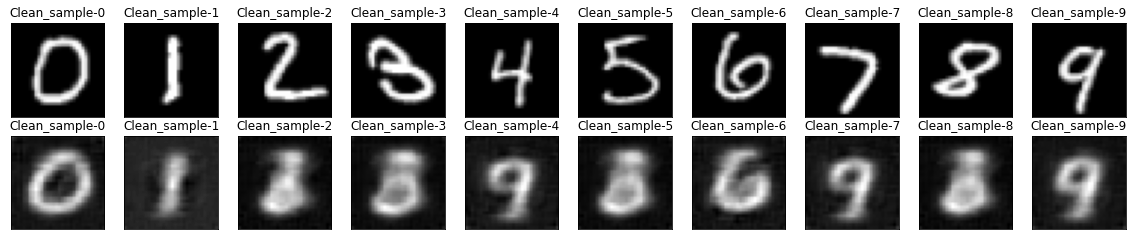

In [47]:
# %% Plot an output after training
# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)


# Load in the model on CPU
device = torch.device('cpu')
model = AE()
model.load_state_dict(torch.load(model_path))
model = model.to(device=device)


with torch.no_grad():
    plt.figure(figsize=(20,10))
    output,_ = model.forward(x_clean_example)
    for i in range(10):
        example = x_clean_example[i,0,:,:]
        example_out =  output[i,0,:,:]
        plt.subplot(5,10,i+1)
        plt.gca().set_title('Clean_sample-'+str(i))
        plt.imshow(example,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(5,10,i+11)
        plt.gca().set_title('Clean_sample-'+str(i))
        plt.imshow(example_out,cmap='gray')
        plt.xticks([])
        plt.yticks([])


# %% HINT
# #hint: if you do not care about going over the data in mini-batches but rather want the entire dataset use:
# x_clean_train = train_loader.dataset.Clean_Images
# x_noisy_train = train_loader.dataset.Noisy_Images
# labels_train  = train_loader.dataset.Labels

# x_clean_test  = test_loader.dataset.Clean_Images
# x_noisy_test  = test_loader.dataset.Noisy_Images
# labels_test   = test_loader.dataset.Labels

# # use these 10 examples as representations for all digits
# x_clean_example = x_clean_test[0:10,:,:,:]
# x_noisy_example = x_noisy_test[0:10,:,:,:]
# labels_example = labels_test[0:10]

In [129]:
####### TRAINING

# Paramters
batch_size = 64
epochs = 10
device =
# get dataloader
train_loader, test_loader = create_dataloaders(data_loc, batch_size)

# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
y_output = Encoder().forward(x_clean_example)
print(y_output)

# Test if the encoder works
if __name__ == "__main__":
    # imports and parameters
    from config_file import data_loc
    import MNIST_dataloader
    import autoencoder_template
    from matplotlib import pyplot as plt
    from MNIST_dataloader import create_dataloaders
    batch_size = 64
    
    # get dataloader
    train_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
    # get some examples
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
    y_output = Encoder().forward(x_clean_example)
    # try out the model before any training
    model = AE()
    output = model.forward(x_noisy_example)
    plt.figure(figsize=(12,3))
    plt.imshow(x_clean_example[0,0,:,:],cmap='gray')
    plt.show()

NameError: name 'create_dataloaders' is not defined